In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import re
import os
from typing import *

In [2]:
def video2frames(vid_path: str, save_path: str) -> None:
    """Convert videos to frame and save frames.

    Args:
        vid_path: path to video
        save_path: path to save frames to
    """
    assert save_path[-1] == "/", f"Requires a directory, {save_path} must end in '/'"
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    vidcap = cv2.VideoCapture(vid_path)
    success, image = vidcap.read()
    count = 0
    while success:
        # save frame as JPEG file
        cv2.imwrite(save_path + f"{count}.jpg", image)
        success, image = vidcap.read()
        count += 1
    print(f"Saved {count} frames to {save_path}.")
    vidcap.release()

video2frames("./data/Records/home.mp4", "./data/frames/home/")


Saved 2012 frames to ./data/frames/home/.


In [2]:
def import_images(path: str) -> List[np.ndarray]:
    """Import all the images of a given directory path and return an array of images

    Args:
        path:(str) path to dir (Make sure path ends in a /)

    Returns:List[np.ndarray] List of images.

    """
    assert path[-1] == "/", f"Requires a directory, {path} must end in a '/'"

    # get file names of frames
    col_frames = os.listdir(path)
    col_frames.sort(key=lambda f: int(re.sub("\D", "", f)))

    # load frames
    col_images = []
    for i in tqdm(col_frames):
        img = cv2.imread(path + i)
        col_images.append(img)
    return col_images


path = "./data/frames/home/"
col_images = import_images(path)
len(col_images)

  0%|          | 0/2012 [00:00<?, ?it/s]

2012

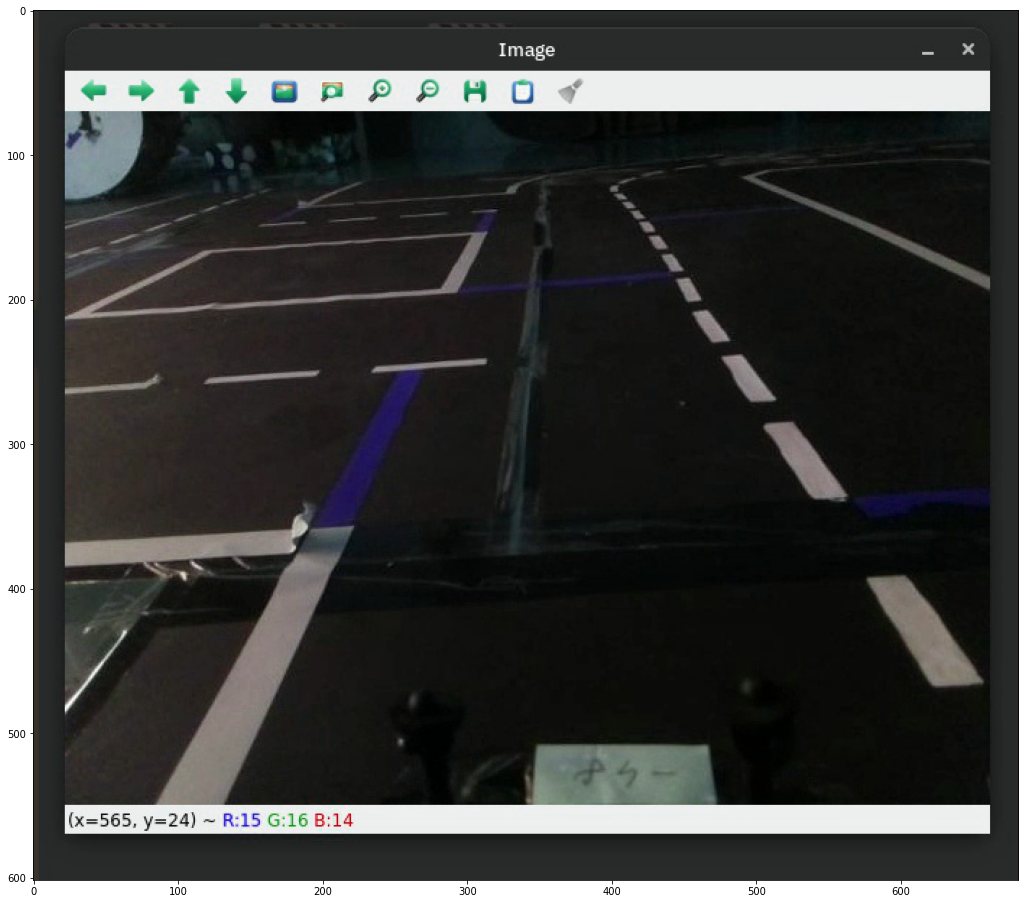

In [12]:
fig, ax1 = plt.subplots(figsize=(20,16))
ax1.imshow(col_images[100])

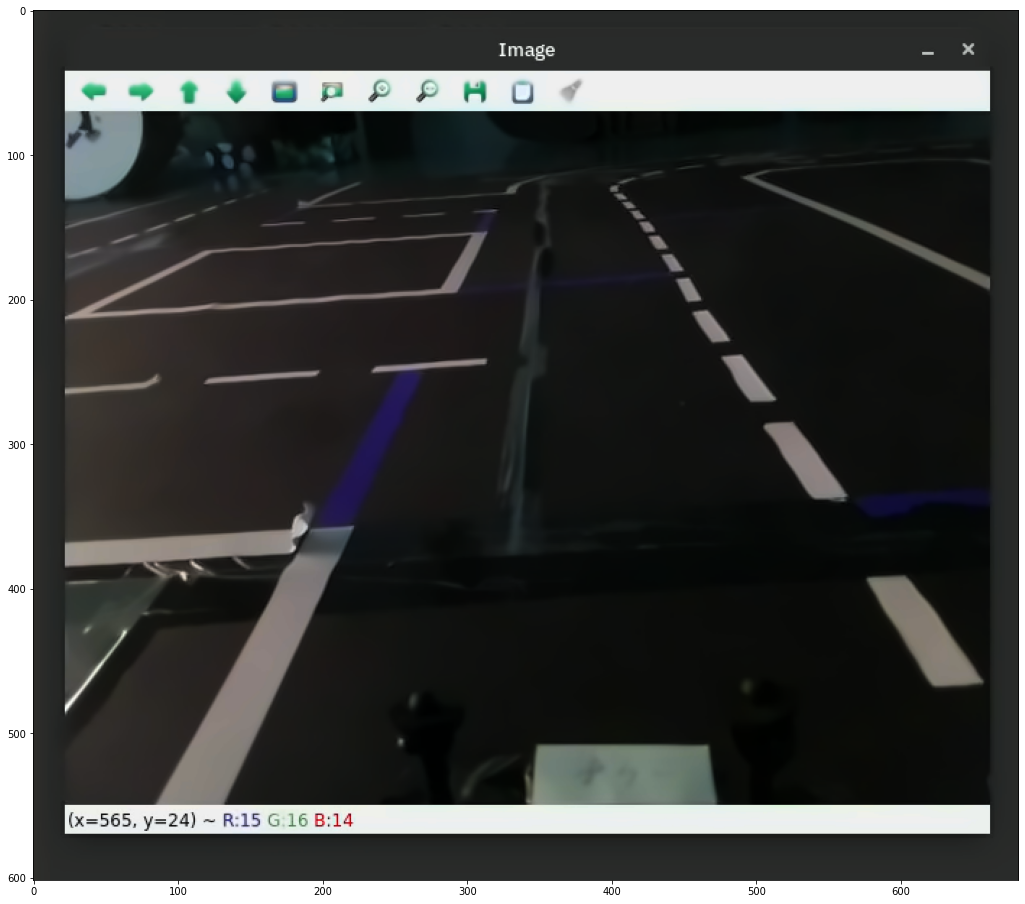

In [21]:
img_denoise = cv2.fastNlMeansDenoisingColored(col_images[100], None, 10, 10, 7, 21)
fig, ax1 = plt.subplots(figsize=(20,16))
ax1.imshow(img_denoise)

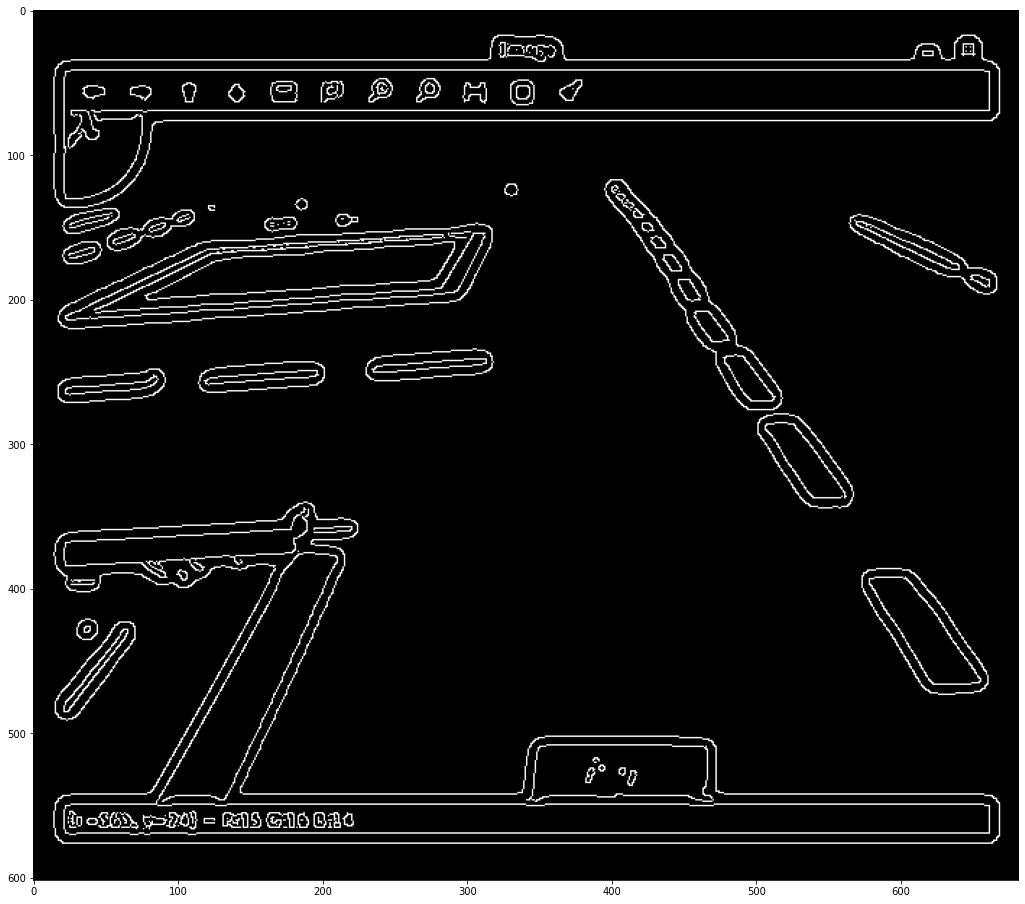

In [20]:
def preprocess(img: np.ndarray) -> np.ndarray:
    """Preprocess image for edge detection"""
    # Apply HLS color filtering to filter out white lane lines
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    lower_white = np.array([90,90,90])  # change here if it fails to detect
    upper_white = np.array([255, 255, 255])
    mask = cv2.inRange(img, lower_white, upper_white)
    hls_result = cv2.bitwise_and(img, img, mask=mask)

    # Convert image to grayscale, apply threshold, blur & extract edges
    gray = cv2.cvtColor(hls_result, cv2.COLOR_BGR2GRAY)
    thres = cv2.adaptiveThreshold(
        gray,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        21,
        4,
    )
    # ret, thresh = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)
    blur = cv2.GaussianBlur(thres, (7, 7), 0)
    canny = cv2.Canny(blur, 40, 60)
    return canny

fig, ax1 = plt.subplots(figsize=(20,16))

ax1.imshow(preprocess(img_denoise), cmap="gray")